In [3]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from mmd import mix_rbf_mmd2
from torch import Tensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
herwig = "../data/events_anomalydetection_DelphesHerwig_qcd_features.h5"
pythiabg = "../data/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5"
pythiasig = "../data/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"

datatypes = ["herwig", "pythiabg", "pythiasig"]
df = {}

df["herwig"] = pd.read_hdf(herwig)
df["pythiabg"] = pd.read_hdf(pythiabg)
df["pythiasig"] = pd.read_hdf(pythiasig)

for datatype in datatypes:
    df[datatype]["tau21j2"] = df[datatype]["tau2j2"] / df[datatype]["tau1j2"]
nsubjetherwig = df["herwig"]["tau21j2"]
data = np.asarray(nsubjetherwig)
data2 = data[0:256]
short_data = data[0:256]
short_data = torch.FloatTensor(short_data)
short_data = short_data.unsqueeze(0)
short_data = short_data.permute(1,0)


In [11]:
class GNet(nn.Module):
    def __init__(self):
        super().__init__()
        model = nn.Sequential(
            nn.Linear(1, 7),
            nn.ELU(),
            nn.Linear(7, 13),
            nn.ELU(),
            nn.Linear(13, 7),
            nn.ELU(),
            nn.Linear(7, 1)
        )
        self.model = model
    def forward(self, input):
        return self.model(input)

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        model = nn.Sequential(
            nn.Linear(1, 11),
            nn.ELU(),
            nn.Linear(11, 29),
            nn.ELU()
        )
        self.model = model
    def forward(self, input):
        return self.model(input)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        model = nn.Sequential(
            nn.Linear(29, 11),
            nn.ELU(),
            nn.Linear(11, 1),
        )
        self.model = model
    def forward(self, input):
        return self.model(input)

In [12]:
def data_sampler(dist_type, dist_param, batch_size=1):
    if dist_type=="gaussian":
        return Tensor(np.random.normal(dist_param[0], dist_param[1], (batch_size, 1))).requires_grad_()

In [94]:
num_iteration = 10000
num_gen = 5
num_enc_dec = 5
lr = 1e-3
batch_size = 256
target_dist = "gaussian"
target_param = (23., 1.)
noise_dist = "gaussian"
noise_param = (0., 1.)


In [95]:


lambda_AE = 8.
# sigma for MMD
base = 1.0
sigma_list = [1, 2, 4, 8, 16]
sigma_list = [sigma / base for sigma in sigma_list]
print_int = 100

gen = GNet()
enc = Encoder()
dec = Decoder()
# lr = (1e-2, 1e-3, 1e-4)
criterion = nn.MSELoss()
gen_optimizer = optim.Adam(gen.parameters(), lr=lr)
enc_optimizer = optim.Adam(enc.parameters(), lr=lr)
dec_optimizer = optim.Adam(dec.parameters(), lr=lr)


In [106]:
from torchsummary import summary
#summary(enc,(11,1))
summary(gen,(256,7,1))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 256, 7, 7]              14
               ELU-2            [-1, 256, 7, 7]               0
            Linear-3           [-1, 256, 7, 13]             104
               ELU-4           [-1, 256, 7, 13]               0
            Linear-5            [-1, 256, 7, 7]              98
               ELU-6            [-1, 256, 7, 7]               0
            Linear-7            [-1, 256, 7, 1]               8
Total params: 224
Trainable params: 224
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.75
Params size (MB): 0.00
Estimated Total Size (MB): 0.76
----------------------------------------------------------------


In [109]:
summary(enc,(256,11,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1          [-1, 256, 11, 11]              22
               ELU-2          [-1, 256, 11, 11]               0
            Linear-3          [-1, 256, 11, 29]             348
               ELU-4          [-1, 256, 11, 29]               0
Total params: 370
Trainable params: 370
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.72
Params size (MB): 0.00
Estimated Total Size (MB): 1.73
----------------------------------------------------------------


In [98]:
summary(dec,(29,11,29))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 29, 11, 11]             330
               ELU-2           [-1, 29, 11, 11]               0
            Linear-3            [-1, 29, 11, 1]              12
Total params: 342
Trainable params: 342
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.06
Params size (MB): 0.00
Estimated Total Size (MB): 0.09
----------------------------------------------------------------


cum_dis_loss -0.15151077390648424, cum_gen_loss 0.02668490332644433


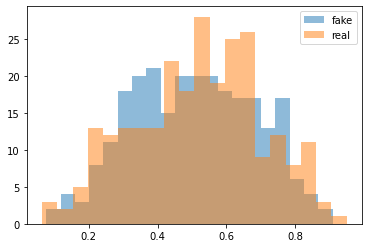

cum_dis_loss 0.030881423025391996, cum_gen_loss 0.033739158665761354


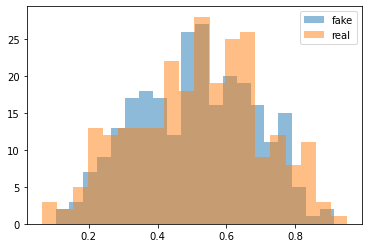

cum_dis_loss 0.04744298450089991, cum_gen_loss 0.049781009948812426


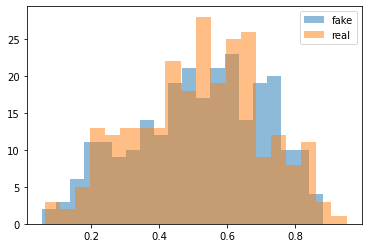

cum_dis_loss 0.061546564742922784, cum_gen_loss 0.06187842211127281


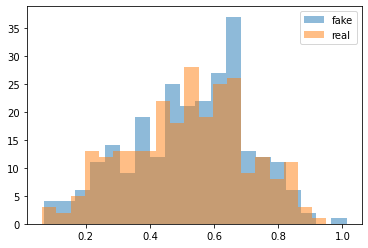

cum_dis_loss 0.07131851323321461, cum_gen_loss 0.07677801301330328


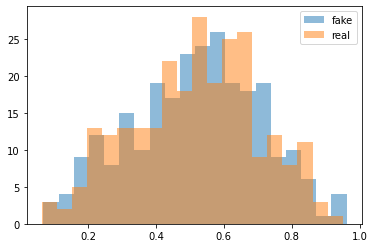

cum_dis_loss 0.08912763131782413, cum_gen_loss 0.08929918698593974


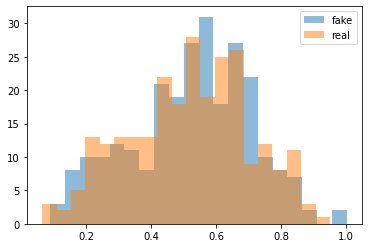

cum_dis_loss 0.10011111719161273, cum_gen_loss 0.10216535985469818


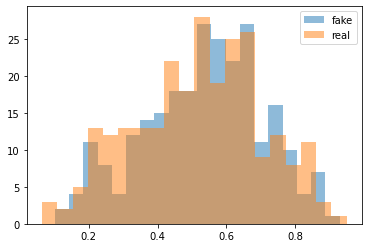

cum_dis_loss 0.10471044012904167, cum_gen_loss 0.11048215935379267


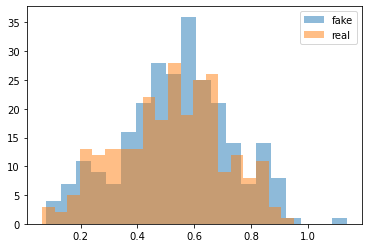

cum_dis_loss 0.11833328092098236, cum_gen_loss 0.11856961861252785


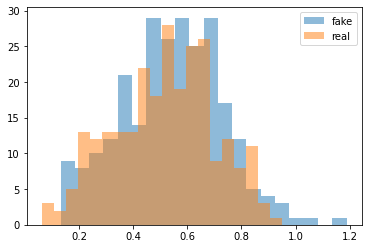

cum_dis_loss 0.12297412231564522, cum_gen_loss 0.12590660718083382


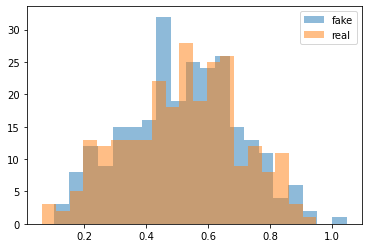

cum_dis_loss 0.13283859552443028, cum_gen_loss 0.13109450670331715


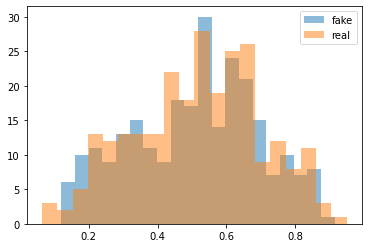

cum_dis_loss 0.13147954891622066, cum_gen_loss 0.1343637548983097


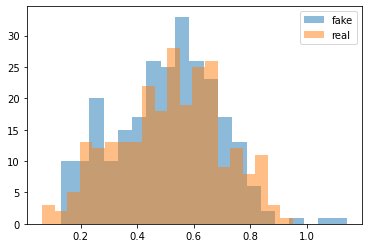

cum_dis_loss 0.13523008401691913, cum_gen_loss 0.13958238853514193


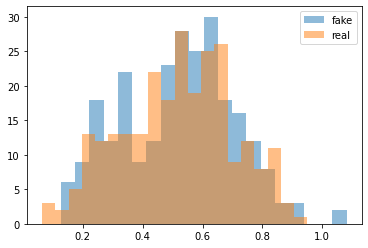

cum_dis_loss 0.14095247922837734, cum_gen_loss 0.14615088944137097


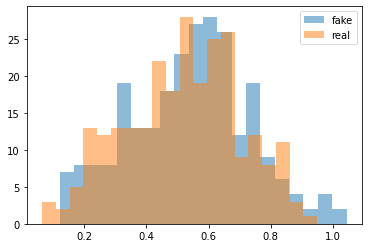

cum_dis_loss 0.14517104221880436, cum_gen_loss 0.14873594775795937


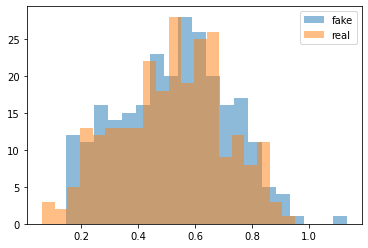

cum_dis_loss 0.15084565226733684, cum_gen_loss 0.15382146809995173


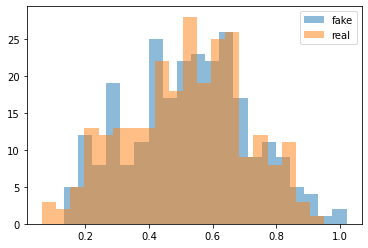

cum_dis_loss 0.15394125108420847, cum_gen_loss 0.15705280764400958


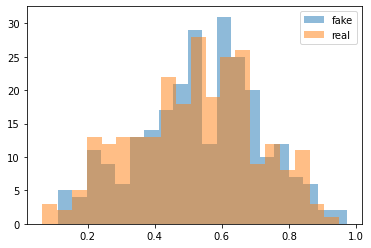

cum_dis_loss 0.15365269984304905, cum_gen_loss 0.1587013368755579


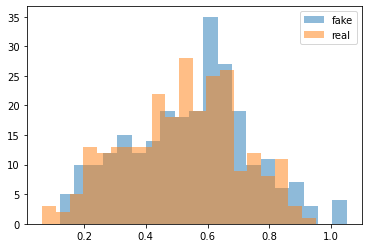

cum_dis_loss 0.15863743576407432, cum_gen_loss 0.16106094481050967


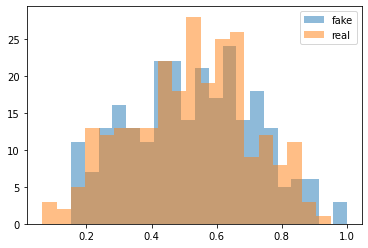

cum_dis_loss 0.16026644372940063, cum_gen_loss 0.16245729218423366


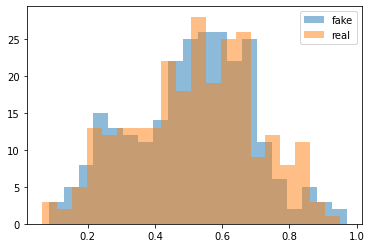

cum_dis_loss 0.1633345122486353, cum_gen_loss 0.1637778073400259


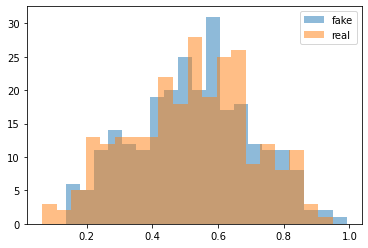

cum_dis_loss 0.1618782111853361, cum_gen_loss 0.16458997252583504


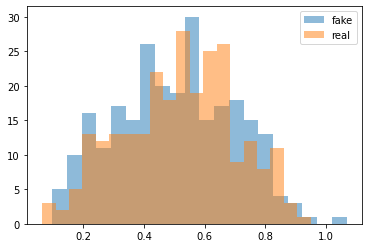

cum_dis_loss 0.16487519325315952, cum_gen_loss 0.16590178874135017


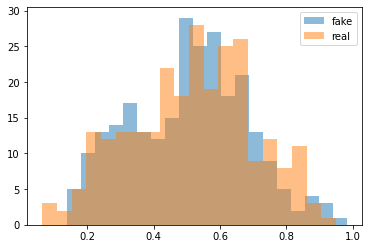

cum_dis_loss 0.16660283508896828, cum_gen_loss 0.16849066181480885


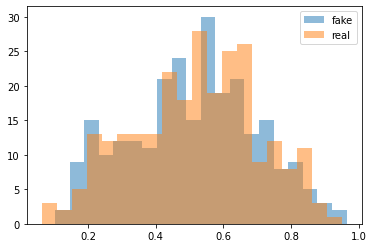

cum_dis_loss 0.16663155320286752, cum_gen_loss 0.17134112122654915


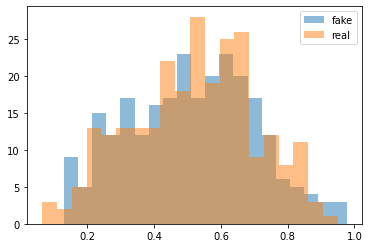

cum_dis_loss 0.1668773369193077, cum_gen_loss 0.17237225168943404


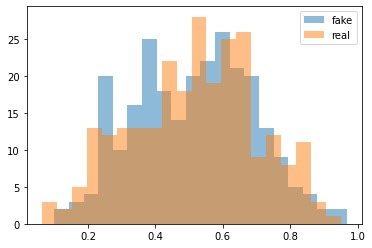

cum_dis_loss 0.17327318224310875, cum_gen_loss 0.17230413229763508


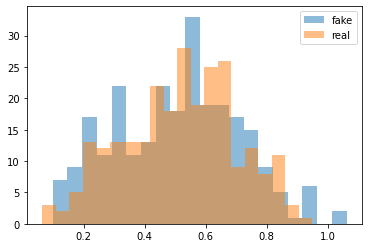

cum_dis_loss 0.16710422149300574, cum_gen_loss 0.17390763160586356


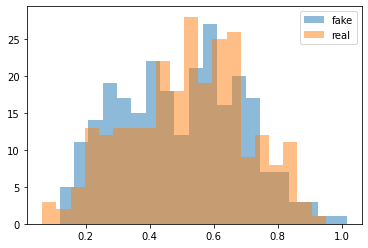

cum_dis_loss 0.173025020390749, cum_gen_loss 0.17639035919308663


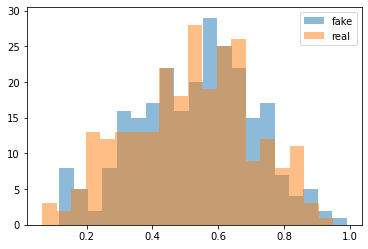

cum_dis_loss 0.17494040408730507, cum_gen_loss 0.17465068089962005


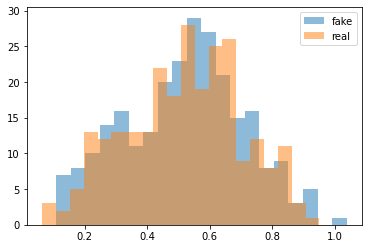

cum_dis_loss 0.17383084461092949, cum_gen_loss 0.1754409567117691


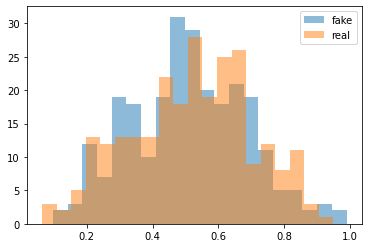

cum_dis_loss 0.1752357846200466, cum_gen_loss 0.1754737457036972


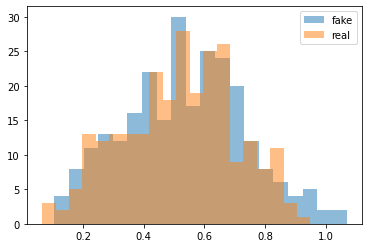

cum_dis_loss 0.17611603520810604, cum_gen_loss 0.17845159024000168


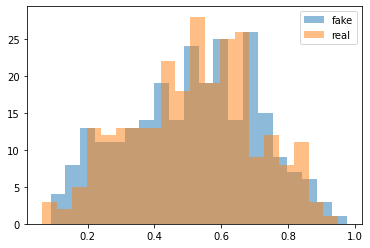

cum_dis_loss 0.17571143467724323, cum_gen_loss 0.17816214443743228


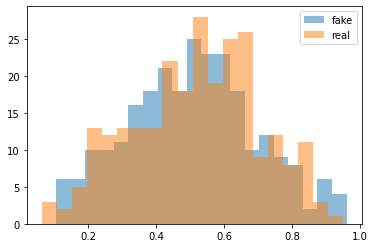

cum_dis_loss 0.17921521472930907, cum_gen_loss 0.17902756741642953


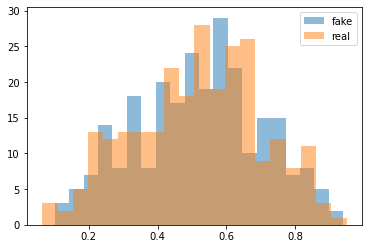

cum_dis_loss 0.17542736688256264, cum_gen_loss 0.17978343790769577


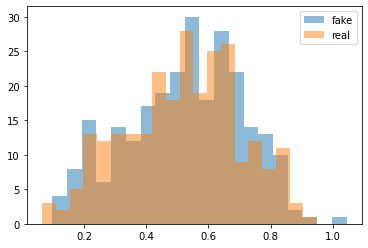

cum_dis_loss 0.17784858909249307, cum_gen_loss 0.18014700454473495


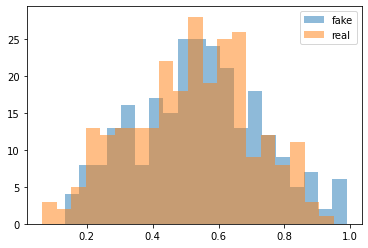

cum_dis_loss 0.17772615298628808, cum_gen_loss 0.17981594929099082


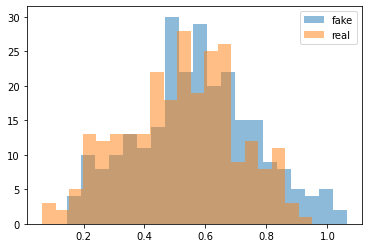

cum_dis_loss 0.1793501105904579, cum_gen_loss 0.18241017630696296


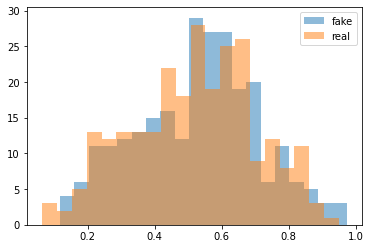

cum_dis_loss 0.1755741284787655, cum_gen_loss 0.17932205444574356


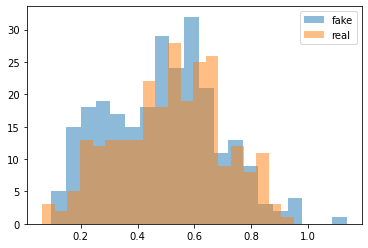

cum_dis_loss 0.1816364645063877, cum_gen_loss 0.18137083736062048


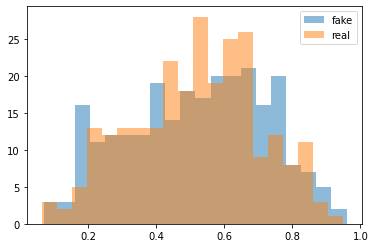

cum_dis_loss 0.1812065789103508, cum_gen_loss 0.1814348808825016


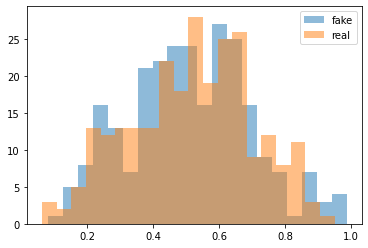

cum_dis_loss 0.17963366383314133, cum_gen_loss 0.18161912298202515


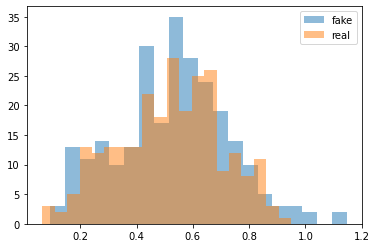

cum_dis_loss 0.18132279486954211, cum_gen_loss 0.1832045437693596


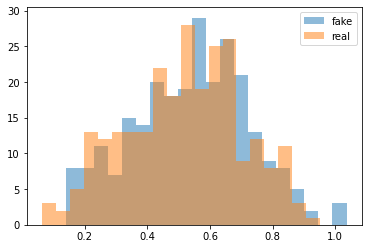

cum_dis_loss 0.18084112533926963, cum_gen_loss 0.18286086684465408


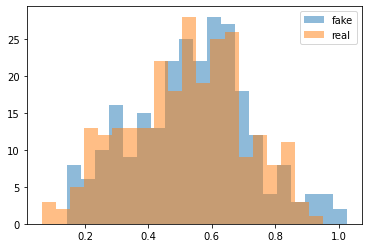

cum_dis_loss 0.17842218087613582, cum_gen_loss 0.1814289534986019


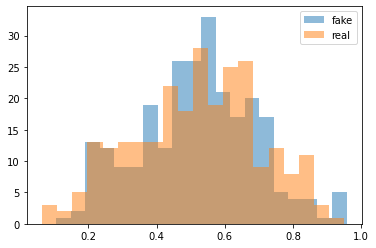

cum_dis_loss 0.18191190776228905, cum_gen_loss 0.18273997929692268


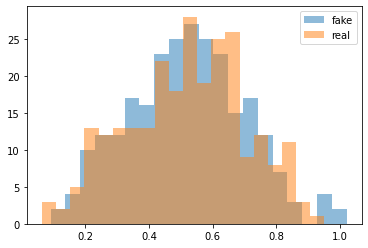

cum_dis_loss 0.1800152563303709, cum_gen_loss 0.1817337155342102


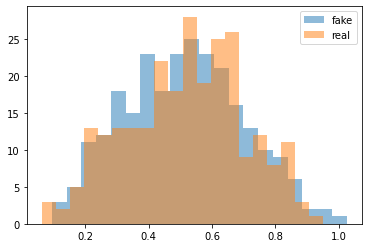

cum_dis_loss 0.1813606718480587, cum_gen_loss 0.1820866014957428


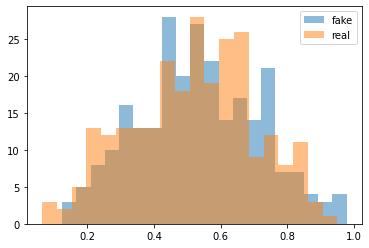

cum_dis_loss 0.17779364471137524, cum_gen_loss 0.18090554255247115


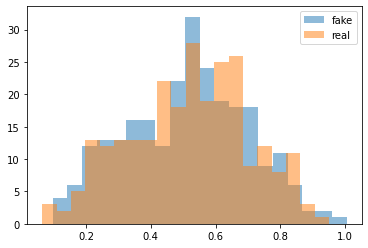

cum_dis_loss 0.18033671170473098, cum_gen_loss 0.18221290791034697


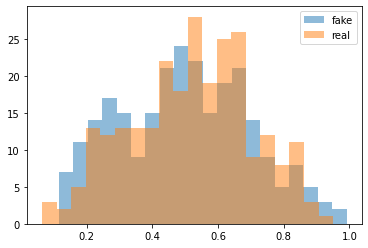

cum_dis_loss 0.17905612727999687, cum_gen_loss 0.18295858415961266


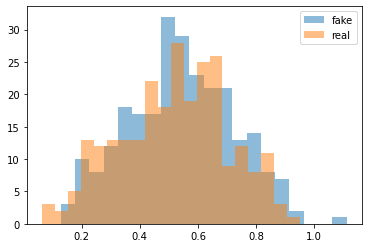

cum_dis_loss 0.18450621670484543, cum_gen_loss 0.18303760892152787


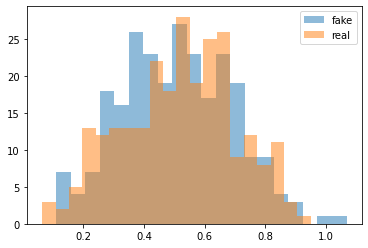

cum_dis_loss 0.18174193094670774, cum_gen_loss 0.18316166734695435


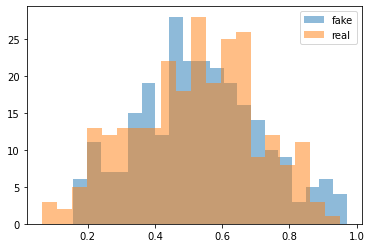

cum_dis_loss 0.18147047302126884, cum_gen_loss 0.18317041221261024


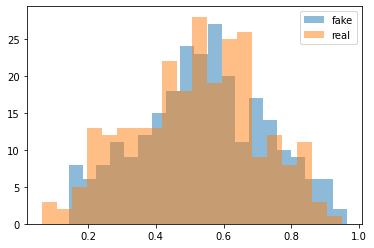

cum_dis_loss 0.1787532034367323, cum_gen_loss 0.18204936522245407


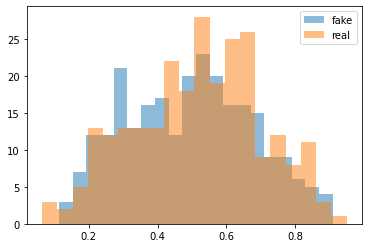

cum_dis_loss 0.18146071687340737, cum_gen_loss 0.18295391118526458


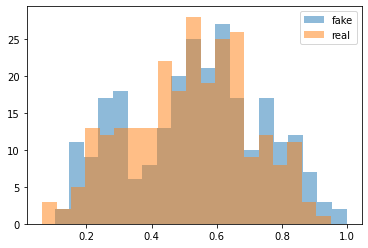

cum_dis_loss 0.1829668940603733, cum_gen_loss 0.1833637045621872


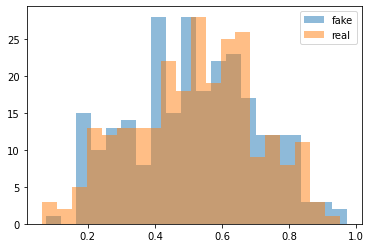

cum_dis_loss 0.18064709091186523, cum_gen_loss 0.18217816707491874


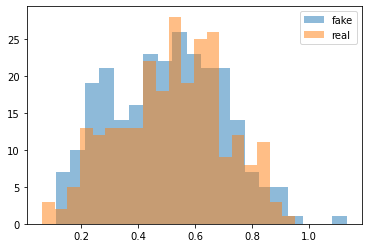

cum_dis_loss 0.18240202197432517, cum_gen_loss 0.18336886569857597


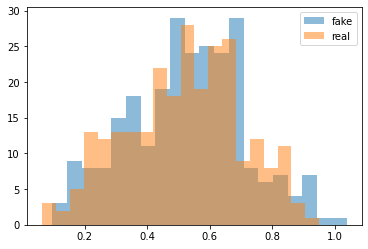

cum_dis_loss 0.18152862904965877, cum_gen_loss 0.18389365902543067


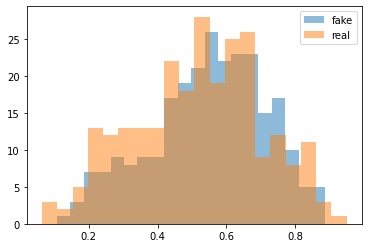

cum_dis_loss 0.1773211742043495, cum_gen_loss 0.18462724056839944


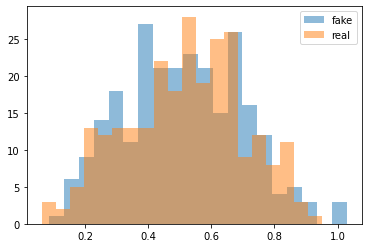

cum_dis_loss 0.18310168477892877, cum_gen_loss 0.18253366521000863


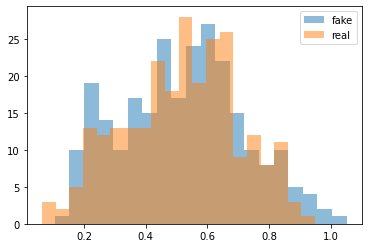

cum_dis_loss 0.184360110104084, cum_gen_loss 0.18439181667566298


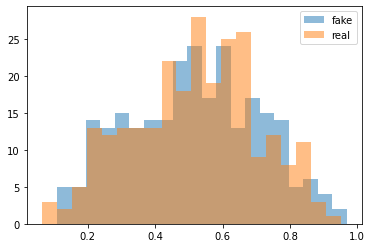

cum_dis_loss 0.18237014096975326, cum_gen_loss 0.18353576534986496


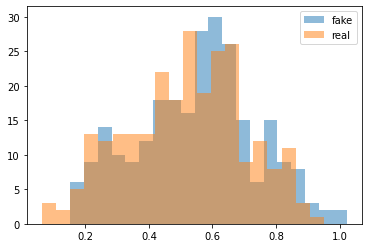

cum_dis_loss 0.1789032006263733, cum_gen_loss 0.1834340242743492


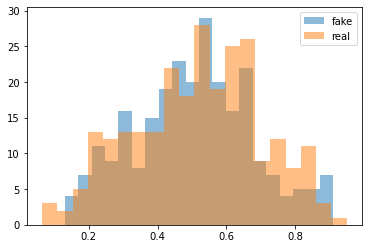

cum_dis_loss 0.17982164004445075, cum_gen_loss 0.18352277430891992


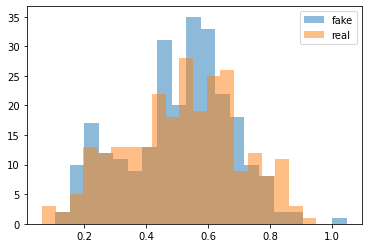

cum_dis_loss 0.17885992631316186, cum_gen_loss 0.18243974041938782


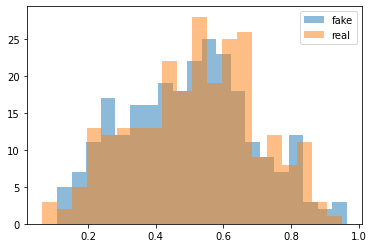

cum_dis_loss 0.18306444910168648, cum_gen_loss 0.1841098731160164


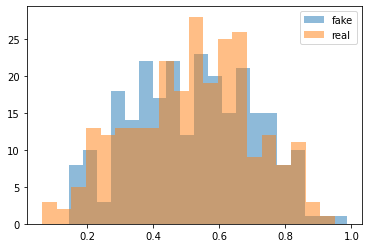

cum_dis_loss 0.18123847818374633, cum_gen_loss 0.18320734471082686


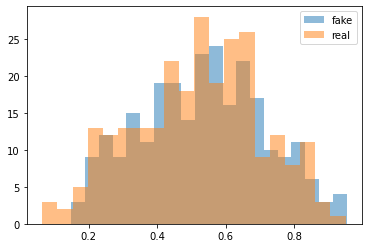

cum_dis_loss 0.18103708264231683, cum_gen_loss 0.18166785424947737


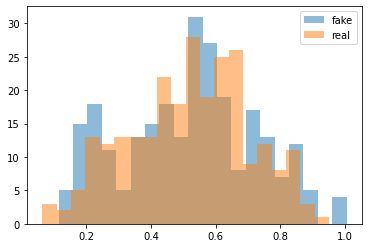

cum_dis_loss 0.1811559675037861, cum_gen_loss 0.1832127754986286


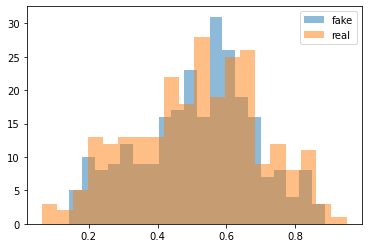

cum_dis_loss 0.1813907784819603, cum_gen_loss 0.18231810903549195


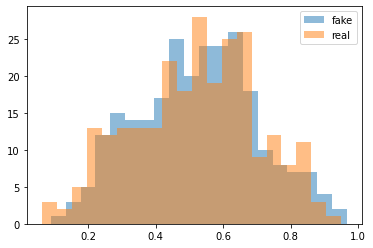

cum_dis_loss 0.18107038524746893, cum_gen_loss 0.18180102559924124


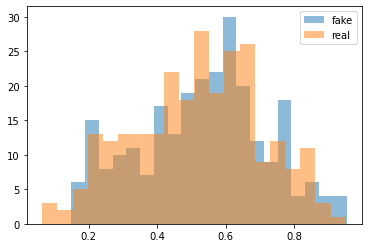

cum_dis_loss 0.17865779596567155, cum_gen_loss 0.18284068062901496


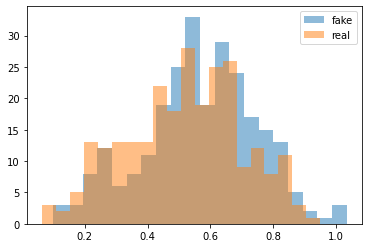

cum_dis_loss 0.18033094578981398, cum_gen_loss 0.18406957536935806


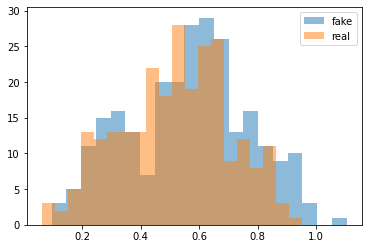

cum_dis_loss 0.18181770139932632, cum_gen_loss 0.1830526322722435


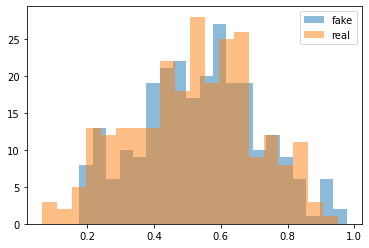

cum_dis_loss 0.1808332696855068, cum_gen_loss 0.18386040219664573


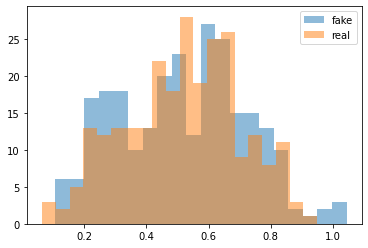

cum_dis_loss 0.18087628111243248, cum_gen_loss 0.18352035555243493


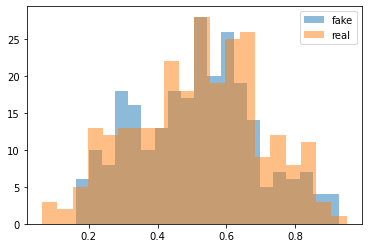

cum_dis_loss 0.18389315378665924, cum_gen_loss 0.1847437589764595


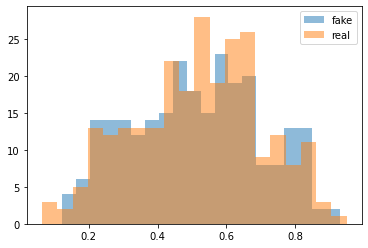

cum_dis_loss 0.18450629994273185, cum_gen_loss 0.18637696799635886


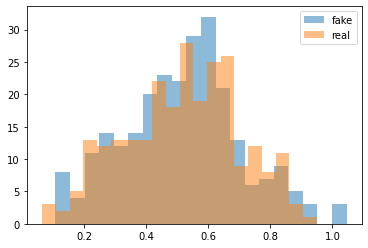

cum_dis_loss 0.18230596113204955, cum_gen_loss 0.18392771112918854


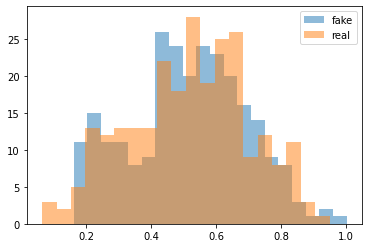

cum_dis_loss 0.1830249722599983, cum_gen_loss 0.18519199898838998


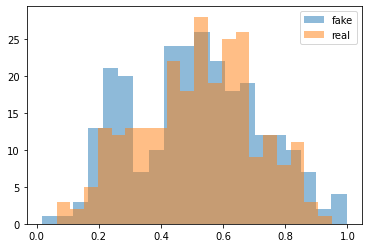

cum_dis_loss 0.18039390613138676, cum_gen_loss 0.18301946431398392


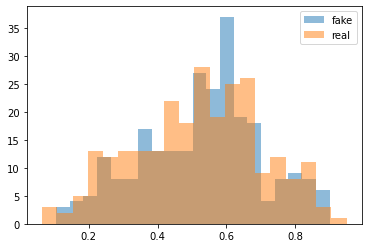

cum_dis_loss 0.18010736960172652, cum_gen_loss 0.18226446124911308


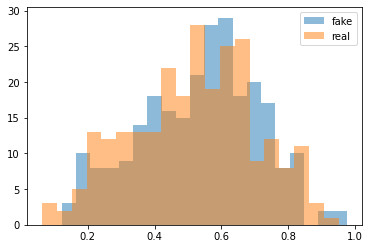

cum_dis_loss 0.18255883085727692, cum_gen_loss 0.18350560200214386


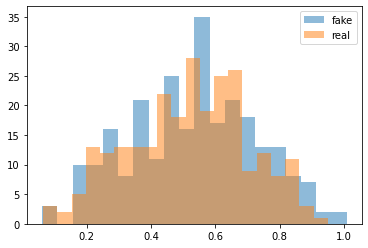

cum_dis_loss 0.181872978746891, cum_gen_loss 0.18438924971222878


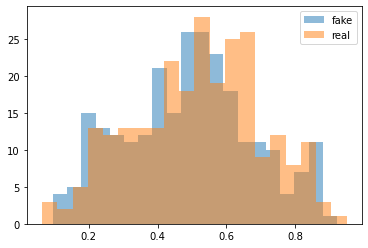

cum_dis_loss 0.18235609954595566, cum_gen_loss 0.18446445962786676


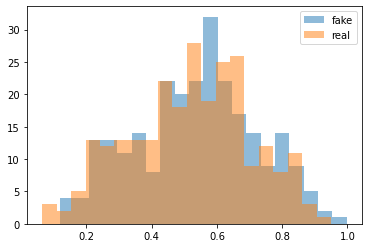

cum_dis_loss 0.1795557637512684, cum_gen_loss 0.18296508726477623


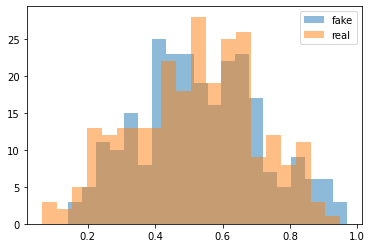

cum_dis_loss 0.18289731541275978, cum_gen_loss 0.1837591037750244


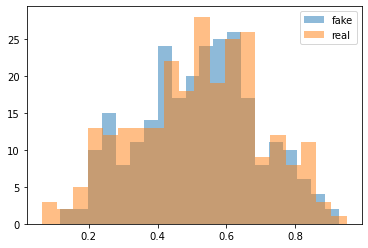

cum_dis_loss 0.18103097742795946, cum_gen_loss 0.18219239750504493


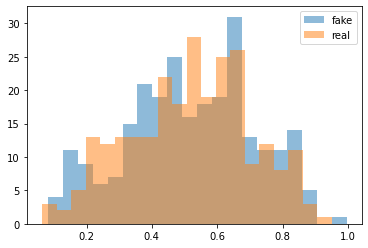

cum_dis_loss 0.18273610939085483, cum_gen_loss 0.18417936837673188


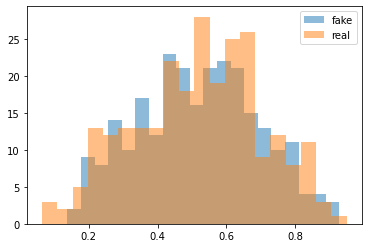

cum_dis_loss 0.18246937894821166, cum_gen_loss 0.18360731574892997


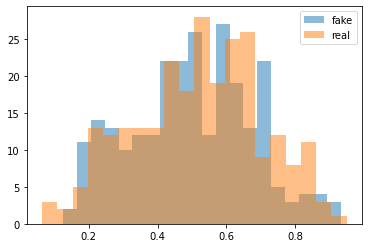

cum_dis_loss 0.1813707420527935, cum_gen_loss 0.18457725483179094


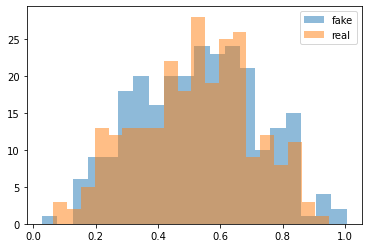

cum_dis_loss 0.18143812480568886, cum_gen_loss 0.1827905184328556


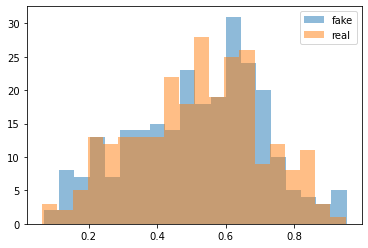

cum_dis_loss 0.18039722687005996, cum_gen_loss 0.18330119505524636


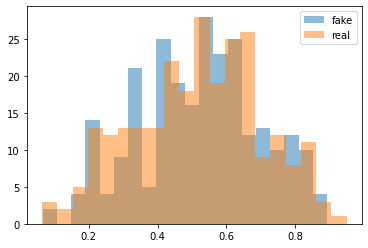

cum_dis_loss 0.181351239874959, cum_gen_loss 0.18365094131231308


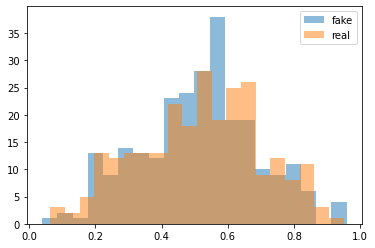

cum_dis_loss 0.18370048159360886, cum_gen_loss 0.18421361565589905


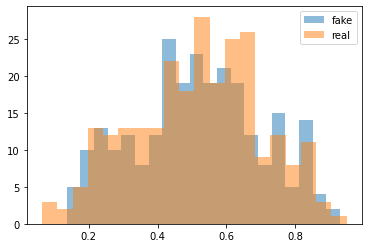

cum_dis_loss 0.18158315677940845, cum_gen_loss 0.1842170081436634


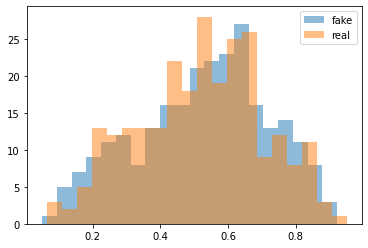

In [99]:

cum_dis_loss = 0
cum_gen_loss = 0
d_loss = []
g_loss = []
for iteration in range(num_iteration):
    for i in range(num_enc_dec):
        enc.zero_grad()
        dec.zero_grad()
        #target = data_sampler(target_dist, target_param, batch_size) #gaussian toy
        target = short_data
        encoded_target = enc.forward(target)
        decoded_target = dec.forward(encoded_target)
        L2_AE_target = (target - decoded_target).pow(2).mean()
        transformed_noise = gen.forward(noise)
        encoded_noise = enc.forward(transformed_noise)
        decoded_noise = dec.forward(encoded_noise)
        L2_AE_noise = (transformed_noise - decoded_noise).pow(2).mean()
        MMD = mix_rbf_mmd2(encoded_target, encoded_noise, sigma_list)
        MMD = F.relu(MMD)
        L_MMD_AE = -1 * (torch.sqrt(MMD)-lambda_AE*(L2_AE_noise+L2_AE_target))
        L_MMD_AE.backward()
        enc_optimizer.step()
        dec_optimizer.step()
        cum_dis_loss = cum_dis_loss - L_MMD_AE.item()
        d_loss.append(-L_MMD_AE.item())
    for i in range(num_gen):
        gen.zero_grad()
        #target = data_sampler(target_dist, target_param, batch_size) #gaussian toy
        target = short_data
        noise = data_sampler(noise_dist, noise_param, batch_size)
        encoded_target = enc.forward(target)
        encoded_noise = enc.forward(gen.forward(noise))
        MMD = torch.sqrt(F.relu(mix_rbf_mmd2(encoded_target, encoded_noise, sigma_list)))
        MMD.backward()
        gen_optimizer.step()
        cum_gen_loss = cum_gen_loss + MMD.item()
        g_loss.append(MMD.item())
    if iteration % print_int == 0 and iteration != 0:
        print('cum_dis_loss {}, cum_gen_loss {}'.format(cum_dis_loss/(print_int*num_enc_dec), cum_gen_loss/(print_int*num_gen)))
        cum_dis_loss = 0
        cum_gen_loss = 0
        target = short_data
        target = target.data.numpy().reshape(batch_size)
        noise = data_sampler(noise_dist, noise_param, batch_size)
        transformed_noise = gen.forward(noise)
        transformed_noise = transformed_noise.data.numpy().reshape(batch_size)

        # plt.hist(target, 20)
        plt.hist(transformed_noise, 20,label="fake",alpha=0.5)
        plt.hist(target,20,label="real",alpha=0.5)
        plt.legend()
        plt.show()



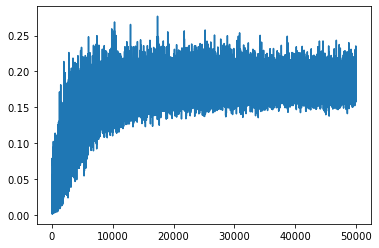

In [110]:
#plt.plot(d_loss)
plt.plot(g_loss)